In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import xarray
import os.path as path
import datetime as dt
import warnings
import cosmicsense as cs
import glob
import os
import copy
import matplotlib.animation as animation
import wradlib
from scipy.optimize import minimize_scalar, minimize
import scipy.stats as stats
from scipy import spatial
from matplotlib.colors import rgb2hex
from IPython.display import Image
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
import glob
import os
import pandas as pd
import numpy as np
import shutil
from pathlib import Path
import os.path as path
import sys

In [48]:
sddir = "/home/maik/b2drop/cosmicsense/inbox/fendt/timeseries/crns/JFC-1-sd/"
remotedir = "/home/maik/b2drop/cosmicsense/inbox/fendt/timeseries/crns/JFC-1/"
trgdir = "/media/x/cosmicsense/data/fendt/crns/spectra"
tmpfile = "tmpfile.txt"
ids = [2]
start_time = "2019-05-01 00:00:00"
end_time = "2019-07-22 00:00:00"

ids = [1, 2, 3, 4, 5, 6, 7, 8, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25]

In [60]:
for i, id in enumerate(ids):
    print("-------------")
    print("Processing %d" % id)

    try:
        os.remove(tmpfile)
    except:
        pass

    # REMOTE FILES
    print("Remote: ", end="")
    #searchdir = os.path.join(remotedir,"%d" % id, crns[id]["remotepattern"])
    searchdir = os.path.join(remotedir,"%d" % id, "up%d_NPMDiag*.%03d_*.dat" % (id,id))
    remotefiles = glob.glob(searchdir, recursive=True)
    print("found %d files" % len(remotefiles))

    for name in remotefiles:
        print(".", end="")
        fin = open(name, "r")
        lines = fin.readlines()
        if len(lines)==0:
            continue
        if not "Diagnostics" in lines[0]:
            continue
        for line in lines:
            # replace comment character
            if line[0:2]=="//":
                continue
            if len(line)<10:
                continue
            line = line.replace("CRS#1,", "")
            line = line.replace("CRS#2,", "")
            myfile = open(tmpfile, 'a')
            myfile.write(line)
            myfile.write("\r\n")
        myfile.close()
    print("")

    # SD
    print("SD: ", end="")
    searchdir = os.path.join(sddir, "%d" % id)
    #sdfiles = [filename for filename in Path(searchdir).glob("**/"+crns[id]["sdpattern"])]
    sdfiles = [filename for filename in Path(searchdir).glob("**/"+"Hist1.DAT")]
    print("found %d files" % len(sdfiles))
    if len(sdfiles)==0:
        print("NO FILES FOR #%d" % id)
        continue

    for name in sdfiles:
        print(".", end="")
        fin = open(name, "r")
        body = fin.read()
        # replace comment character
        body = body.replace("//", "#")
        myfile = open(tmpfile, 'a')
        myfile.write(body)
        myfile.close()
    print("")

    # MERGE
    df = pd.read_csv(tmpfile, sep=",", comment="#", header=None, error_bad_lines=False, warn_bad_lines=True)
    columns = list(df.columns)
    columns[0] = "datetime"
    df.columns = columns
    df["datetime"] = pd.to_datetime(df["datetime"], format="%Y/%m/%d %H:%M:%S")
    df = df.set_index("datetime")
    #df.insert(loc=0, column="datetime", value=df.index)
    df = df.sort_index()
    df = df[df.index >= start_time]
    df = df[df.index <= end_time]
    dupl = df.index.duplicated(keep='first')
    if np.any(dupl):
        print("Contains %d duplicates" % len(np.where(dupl)[0]))
        df = df[~dupl]
    fpath = os.path.join(trgdir, "%d_CRNS_spectra.txt" % id )
    df.to_csv(fpath, sep="\t", index=True, date_format="%Y-%m-%d %H:%M:%S")

-------------
Processing 1
Remote: found 77 files
.............................................................................
SD: found 1 files
.
Contains 77 duplicates
-------------
Processing 2
Remote: found 68 files
....................................................................
SD: found 4 files
....
Contains 60 duplicates
-------------
Processing 3
Remote: found 69 files
.....................................................................
SD: found 2 files
..
Contains 68 duplicates
-------------
Processing 4
Remote: found 68 files
....................................................................
SD: found 2 files
..
Contains 67 duplicates
-------------
Processing 5
Remote: found 0 files

SD: found 3 files
...
Contains 20 duplicates
-------------
Processing 6
Remote: found 0 files

SD: found 2 files
..
Contains 21 duplicates
-------------
Processing 7
Remote: found 0 files

SD: found 0 files
NO FILES FOR #7
-------------
Processing 8
Remote: found 0 files

SD: found 0 fi

In [90]:
fpath = "/media/x/cosmicsense/data/fendt/crns/spectra/"
crns = {}
for id in ids:
    try:
        df = pd.read_csv(path.join(fpath, "%d_CRNS_spectra.txt" % id), sep="\t")
    except FileNotFoundError:
        continue
    cols = list(df.columns)
    cols[0] = "datetime"
    df.columns = cols                     
    df.datetime = pd.to_datetime(df.datetime)
    df = df.set_index("datetime")
    #if id==1:
    #    df = df["2019-06-15":]
    print("%d: %s to %s" % (id, df.index[0], df.index[-1]) )
    crns[id] = df

1: 2019-05-10 09:39:00 to 2019-08-05 12:42:50
2: 2019-05-08 11:03:00 to 2019-07-15 21:21:56
3: 2019-05-08 08:36:00 to 2019-07-16 04:26:56
4: 2019-05-08 15:25:00 to 2019-07-16 13:19:49
5: 2019-05-08 13:27:00 to 2019-06-04 11:16:00
6: 2019-05-08 09:07:00 to 2019-05-28 10:21:00
14: 2019-05-09 06:44:00 to 2019-07-22 12:18:00
16: 2019-05-04 13:17:00 to 2019-07-16 16:31:00
17: 2019-05-04 13:16:00 to 2019-07-16 14:26:00
18: 2019-05-04 13:21:00 to 2019-07-15 11:58:00
19: 2019-05-04 13:18:00 to 2019-07-16 13:17:00
21: 2019-05-14 17:04:00 to 2019-06-27 08:56:00
22: 2019-05-14 16:09:00 to 2019-05-23 09:39:00
23: 2019-05-01 13:32:00 to 2019-07-16 10:19:00
24: 2019-05-01 12:28:00 to 2019-07-16 15:19:00


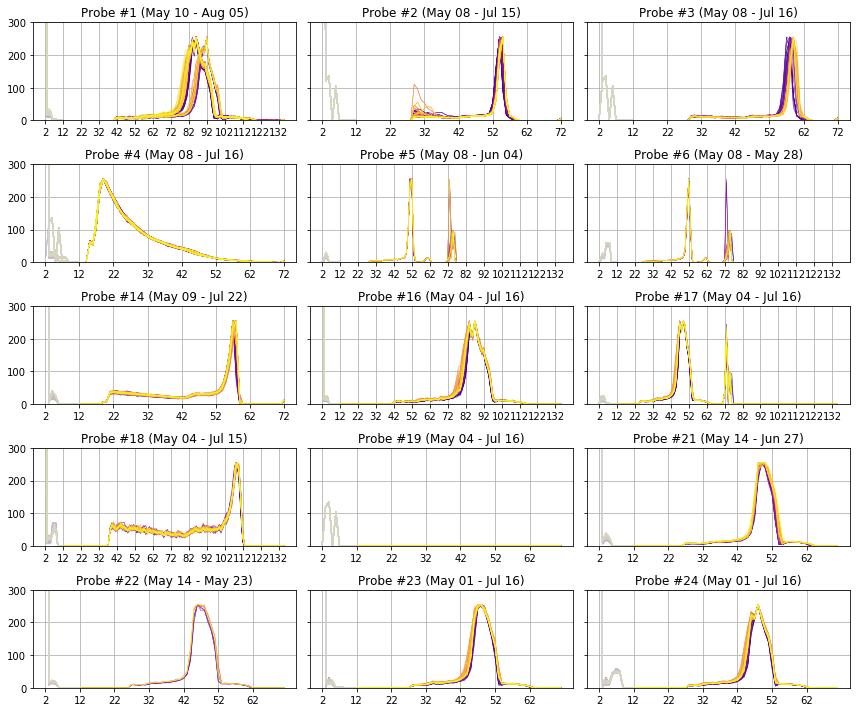

In [136]:
plt.rc('font', **{'size'   : 10})
fig, ax = plt.subplots(nrows=5, ncols=3, sharey=True, figsize=(12,10))
ax = ax.ravel()

for i, id in enumerate(crns.keys()):
    plt.sca(ax[i])
    plt.title("Probe #%d (%s - %s)" % (id,crns[id].index[0].strftime("%b %d"), crns[id].index[-1].strftime("%b %d")))
    colors = plt.cm.plasma(np.linspace(0,1,len(crns[id])))
    for j in range(len(crns[id])):
        plt.plot(crns[id].iloc[j,1:-1], lw=0.5, color=colors[j])
        plt.plot(crns[id].iloc[j,1:12], lw=1, color="lightgrey")
    plt.ylim(0,300)
    ax[i].set_xticks(ax[i].get_xticks()[::10])
    plt.grid()
#fig.autofmt_xdate()  

plt.tight_layout()
plt.savefig("spectra_fendt.png", dpi=150, bbox_inches="tight")

In [82]:
crns[id].loc[crns[id].index[-1]]

1       0
2       0
3      12
4      32
5      23
       ..
132     0
133     0
134     0
135     0
136     0
Name: 2019-06-04 11:16:00, Length: 136, dtype: int64

In [79]:
crns[id]

,1,2,3,4,5,6,7,8,9,10,...,127,128,129,130,131,132,133,134,135,136
datetime,,,,,,,,,,,,,,,,,,,,,
2019-05-08 13:27:00,0,0,4,20,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-09 13:27:00,0,0,8,20,15,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-10 13:27:00,0,0,10,20,15,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-11 13:27:00,0,0,12,20,15,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-12 13:27:00,0,0,8,14,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-13 13:27:00,0,0,8,14,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-14 13:27:00,0,0,4,15,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-15 13:27:00,0,0,7,13,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-16 13:27:00,0,0,5,16,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
